# IMPORTS

In [1]:
# DEPENDENCIES

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# INITIAL CONDITIONS

In [2]:
startTime = 0.0
endTime   = 80.0
timeSteps = 1000
 
# simulation time array 
# we will obtain the solution at the time points defined by 
# the vector simulationTime
simulationTime=np.linspace(startTime,endTime,timeSteps)

# PARAMETERS

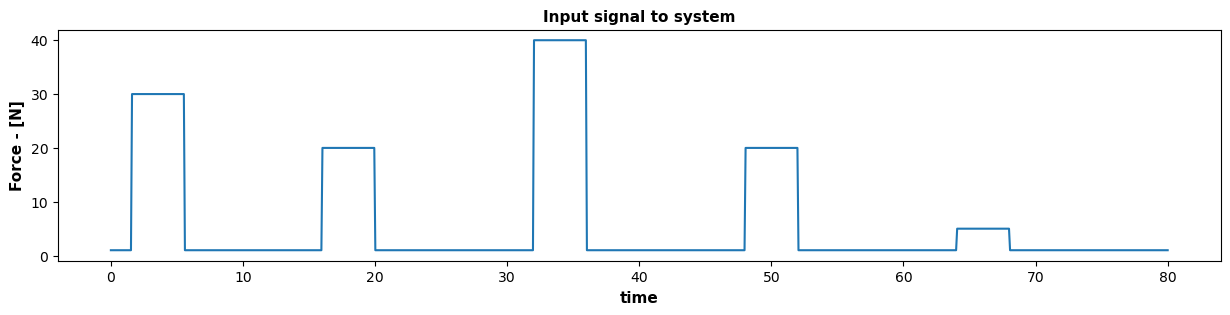

In [3]:
# define the constants
gConstant  = 9.81
lConstant  = 1.0
mConstant  = 5.0
# set cConstant = 0.0 to turn off damping
cConstant  = 4.0
# define the force input 
forceInput = np.ones_like(simulationTime)*1.0
forceInput[20:70]   = 30.0 
forceInput[200:250] = 20.0
forceInput[400:450] = 40.0
forceInput[600:650] = 20.0
forceInput[800:850] = 5.0
# forceInput = np.sin(1.0*simulationTime)
# forceInput = np.sin(0.5*simulationTime)+np.cos(2*simulationTime)
# forceInput = np.zeros_like(simulationTime) + np.random.rand(simulationTime.shape[0])

plt.figure(figsize=(15,3))
plt.title("Input signal to system", fontsize=11, fontweight="bold")
plt.plot(simulationTime, forceInput)
plt.xlabel('time', fontsize=11, fontweight="bold")
plt.ylabel('Force - [N]', fontsize=11, fontweight="bold")
plt.savefig('inputSequence.png',dpi=600)
plt.show()

\begin{equation}
{ X = \begin{bmatrix} {\theta, \dot{\theta}} \end{bmatrix}^{T} }
\end{equation}
\\
\begin{equation}
{ \dot{X} = \begin{bmatrix} {\dot{\theta}, \ddot{\theta}} \end{bmatrix}^{T} }
\end{equation}

+ Where $\theta$ is the c.c.w. rotation of a simple pendulum due to action of external force(t) in that direction.

# STATEE-SPACE MODEL FUNCTION

\begin{equation}
{\zeta^{net} = I\alpha = I\ddot{\theta} = ml^{2}\ddot{\theta}}
\end{equation}

\begin{equation}
{\zeta^{net} = - \left( F_{Gravity-component}*l \right) - \left( F_{Damp/Drag}*l \right) + \left( F_{External}*l \right) }
\end{equation}

\begin{equation}
{F_{Gravity-component} = \left( mg*sin(\theta) \right) }
\end{equation}

\begin{equation}
{F_{Damp/Drag} \quad \alpha \quad \left( \dot{\theta}^{2} \quad or \quad \dot{\theta} \right) }
\end{equation}

In [4]:
# this function defines the state-space model, that is, its right-hand side
# x is the state 
# t is the current time - internal to solver
# timePoints - time points vector necessary for interpolation
# g,l,m constants provided by the user
# forceArray - time-varying input
def stateSpaceModel(x,t,timePoints,g,l,m,c,forceArray):
    # interpolate input force values
    # depending on the current time
    forceApplied=np.interp(t,timePoints, forceArray)
    # NOTE THAT IF YOU KNOW THE ANALYTICAL FORM OF THE INPUT FUNCTION 
    # YOU CAN JUST WRITE THIS ANALYTICAL FORM AS A FUNCTION OF TIME 
    # for example in our case, we can also write
    # forceApplied=np.sin(t)+np.cos(2*t)
    # and you do not need to specity forceArray as an input to the function
    # HOWEVER, IF YOU DO NOT KNOW THE ANALYTICAL FORM YOU HAVE TO USE OUR APPROACH 
    # AND INTERPOLATE VALUES
     
    # right-side of the state equation
    
    alpha_external  = (1/(m*l))*forceApplied
    n = 1.0                                     # n=1.0--> Regular damping model, n=2.0--> Drag force modeling
    alpha_dmaping   = (c/(m))*x[1]**n
    x_1 = x[1]
    x_2 = -(g/l)*np.sin(x[0]) - alpha_dmaping + alpha_external
    
    dxdt = [x_1, x_2]
    return dxdt

# SOLVE

In [5]:
# define the initial state for simulation 
# position and velocity
initialState=np.array([0.0,0.0])
# generate the state-space trajectory
solutionState=odeint(stateSpaceModel,initialState,simulationTime,args=(simulationTime,gConstant,lConstant,mConstant,cConstant,forceInput))

# VISUALIZE

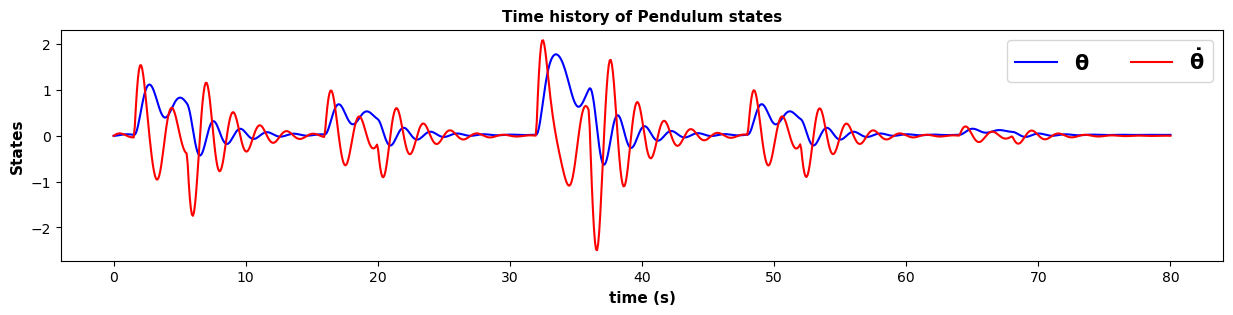

In [6]:
plt.figure(figsize=(15,3))
plt.title("Time history of Pendulum states", fontsize=11, fontweight="bold")
plt.plot(simulationTime, solutionState[:,0] ,color='b',label='$\\bf\\theta$')
plt.plot(simulationTime, solutionState[:,1] ,color='r',label='$\\bf\\dot{\\theta}$')
plt.xlabel('time (s)', fontsize=11, fontweight="bold")
plt.ylabel('States', fontsize=11, fontweight="bold")
plt.legend(ncol=2, fontsize=15);


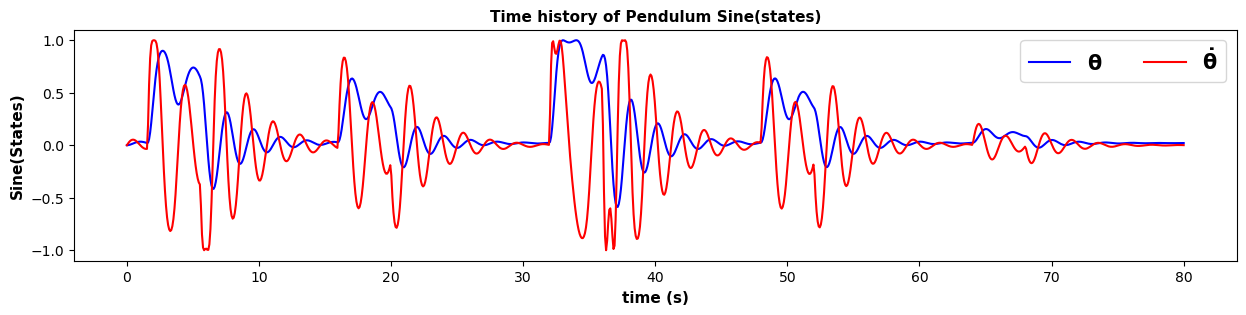

In [7]:
plt.figure(figsize=(15,3))
plt.title("Time history of Pendulum Sine(states)", fontsize=11, fontweight="bold")
plt.plot(simulationTime, np.sin(solutionState[:,0]) ,color='b',label='$\\bf\\theta$')
plt.plot(simulationTime, np.sin(solutionState[:,1]) ,color='r',label='$\\bf\\dot{\\theta}$')
plt.xlabel('time (s)', fontsize=11, fontweight="bold")
plt.ylabel('Sine(States)', fontsize=11, fontweight="bold")
plt.legend(ncol=2, fontsize=15);

**NOTE**:
+ $\dot{X}$ is tangent to the instantaneous trajectory of the Phase space.
+ Projections of $\dot{X}$ in each axis in Phase space is it's instantenous states.

# Computing mesh grid for initial state

In [8]:
# Define a grid of points at which we will show arrows
x_mesh0=np.linspace(np.min(solutionState[:,0])*1.1,np.max(solutionState[:,0])*1.1,30)
x_mesh1=np.linspace(np.min(solutionState[:,1])*1.1,np.max(solutionState[:,1])*1.1,30)
 
# create a grid
X_mesh0,X_mesh1=np.meshgrid(x_mesh0, x_mesh1)

# projections of the trajectory tangent vector 
dX0=np.zeros(X_mesh0.shape)
dX1=np.zeros(X_mesh1.shape)

shape1,shape2=X_mesh1.shape


# Computing X_dot at t=0.0 (initial time) for various possible states (x_mesh0 & x_mesh1)
# Computing X_dot is only calculating without integration. Only R.H.S. 
## X_dot is required to add quivers (X_dot is tangent to a state trajectory) in phase space.
i, j = 0.0, 0.0
for i in range(shape1):
    for j in range(shape2):
        
        X_input = [X_mesh0[i,j], X_mesh1[i,j]]
        dxdt_at_Xij = stateSpaceModel(X_input, simulationTime[0:1], simulationTime[0:1], gConstant, lConstant, mConstant, cConstant, forceInput[0:1])
        dX0[i,j]    = dxdt_at_Xij[0]
        dX1[i,j]    = dxdt_at_Xij[1]


endstate = solutionState[-1:]
print(f"Initial_State: {initialState}")
print(f"End_State:     {endstate[0]}")

Initial_State: [0. 0.]
End_State:     [0.0208427  0.00079579]


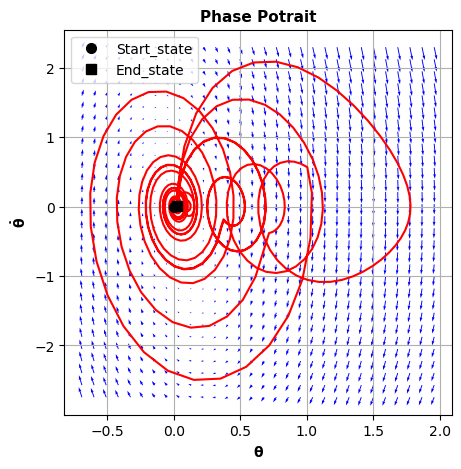

In [9]:
plt.figure(figsize=(5,5))
line_width  = 1.5
marker_size = 7
plt.title("Phase Potrait", fontsize=11, fontweight="bold")
# Initial tangents(X_dot)
plt.quiver(X_mesh0,X_mesh1,dX0,dX1,color='b')
plt.plot(solutionState[:,0], solutionState[:,1],"r", lw=line_width);
plt.plot(initialState[0],initialState[1], "o",color="k", label="Start_state", ms=marker_size)
plt.plot(endstate[0,0],endstate[0,1], "s",color="k",label="End_state", ms=marker_size)
plt.xlabel("$\\bf\\theta$")
plt.ylabel("$\\bf\dot{\\theta}$")
plt.legend(loc=0);
plt.grid();

## Further:
+ Recurrence analysis
+ Phase-space reconstructions ...